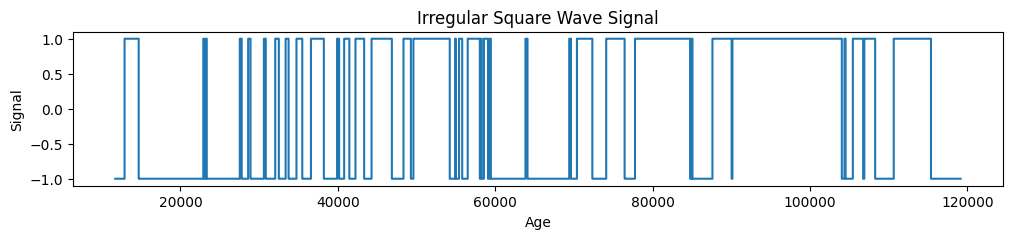

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given ground truth intervals for the low phase (-1)
gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}

# Create an age vector (baseline resolution e.g. every 10 years)
ages = np.arange(11703, 119140, 1)

# Initialize signal at +1
signal = np.ones_like(ages)

# Flip to -1 during the specified low-phase intervals
for start, end in zip(gs_data["start"], gs_data["end"]):
    mask = (ages >= start) & (ages <= end)
    signal[mask] = -1

# Build a DataFrame for clarity
df_sq = pd.DataFrame({"age": ages, "sq": signal})

# Plot the irregular square wave
plt.figure(figsize=(12, 2))
plt.step(df_sq["age"], df_sq["sq"], where="post")
plt.xlabel("Age")
plt.ylabel("Signal")
plt.title("Irregular Square Wave Signal")
plt.show()


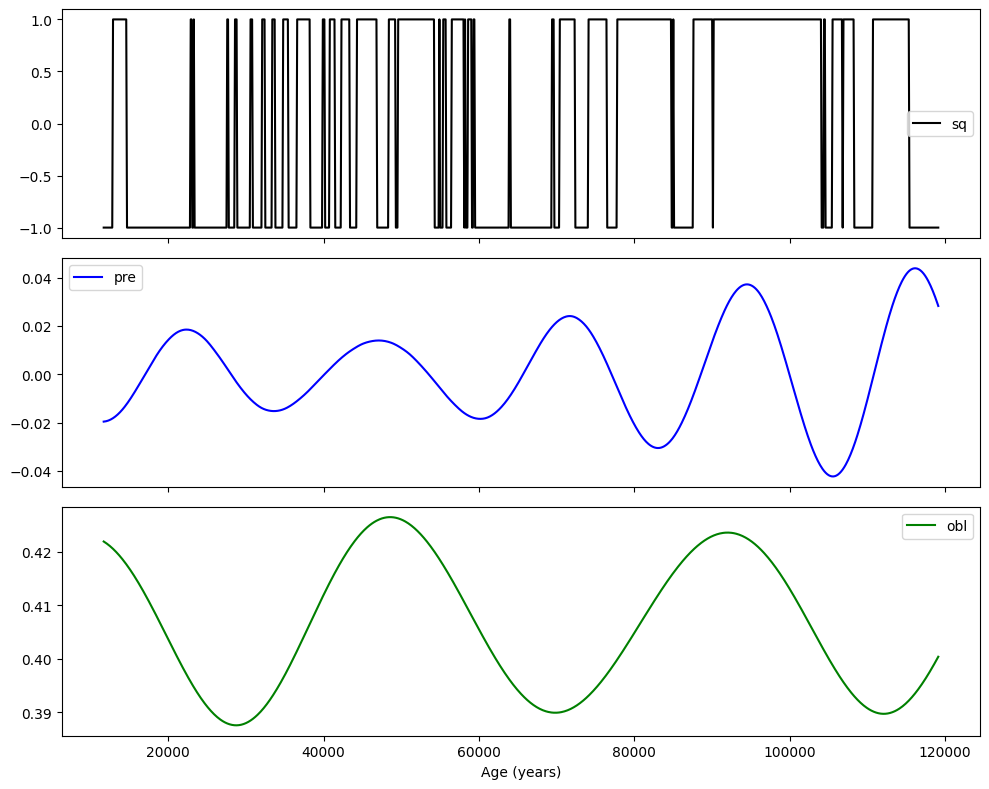

         age   sq
0      11703 -1.0
1      11803 -1.0
2      11903 -1.0
3      12003 -1.0
4      12103 -1.0
...      ...  ...
1070  118703 -1.0
1071  118803 -1.0
1072  118903 -1.0
1073  119003 -1.0
1074  119103 -1.0

[1075 rows x 2 columns]
         age       pre
0      11703 -0.019594
1      11803 -0.019558
2      11903 -0.019507
3      12003 -0.019440
4      12103 -0.019359
...      ...       ...
1070  118703  0.031952
1071  118803  0.031067
1072  118903  0.030157
1073  119003  0.029223
1074  119103  0.028265

[1075 rows x 2 columns]
Length of df_sq_rs: 1075


In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 100, if_plot=True)



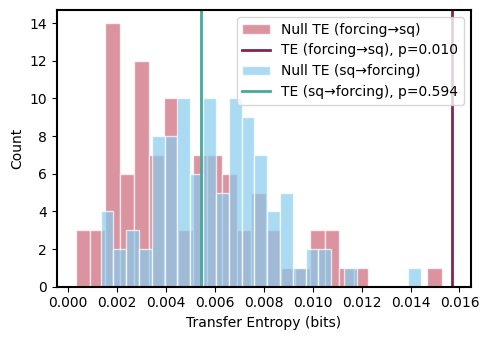

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq)
result
fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=100, if_plot=False)

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq)
result
fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

# Change in smoothing length

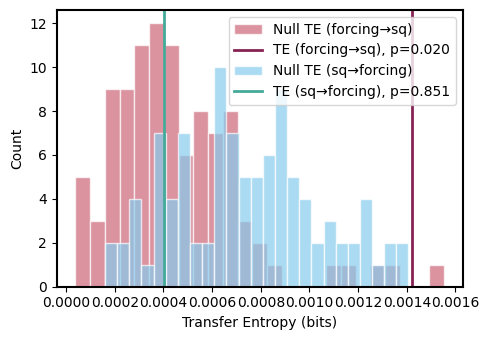

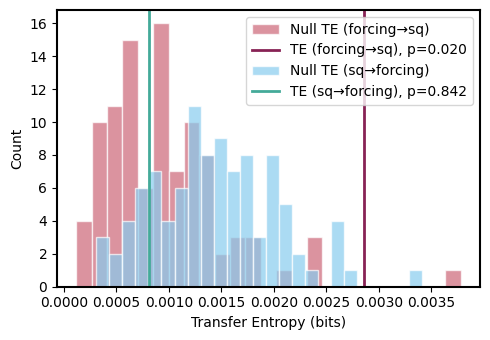

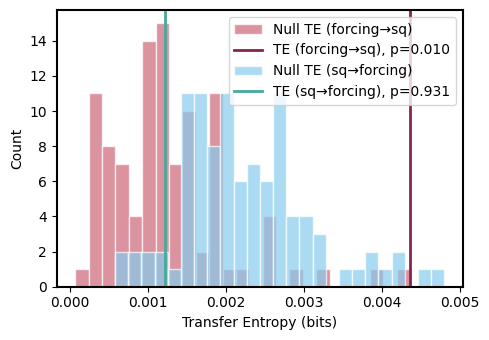

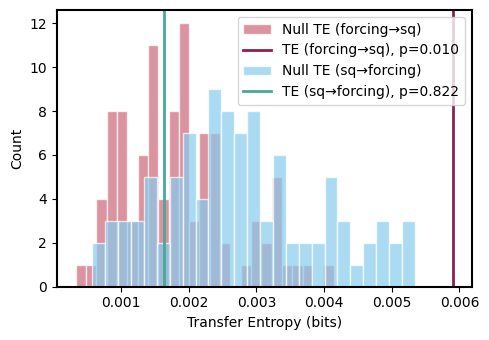

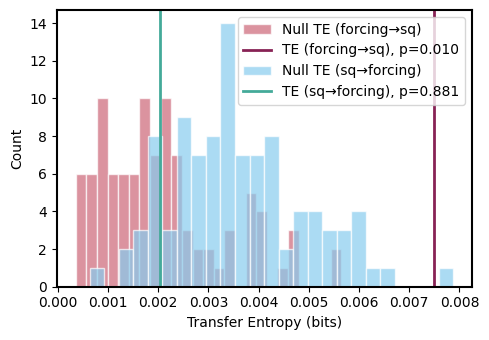

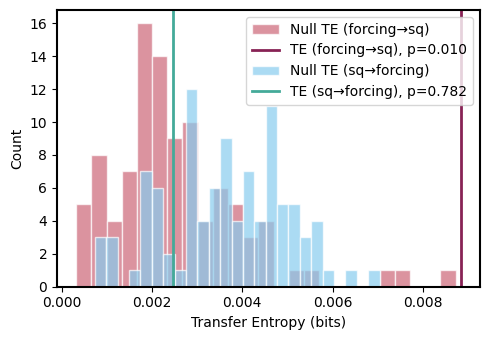

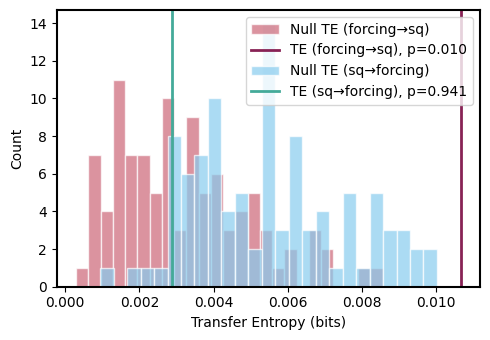

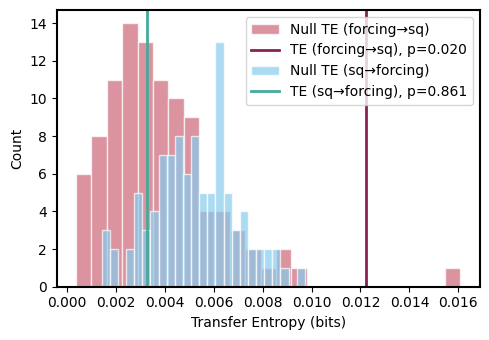

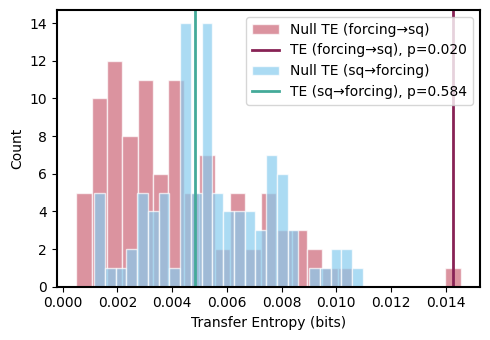

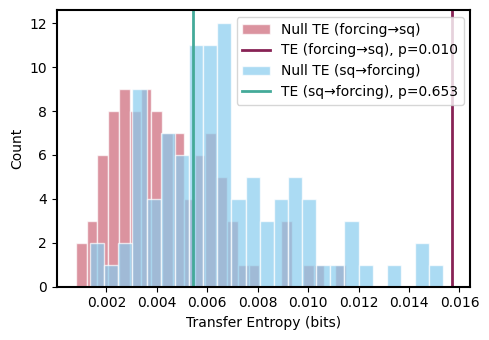

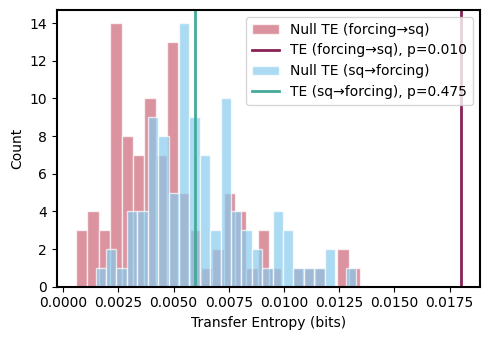

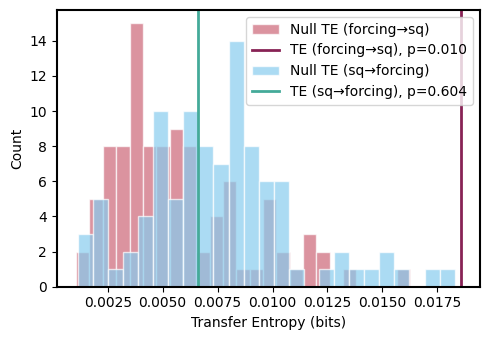

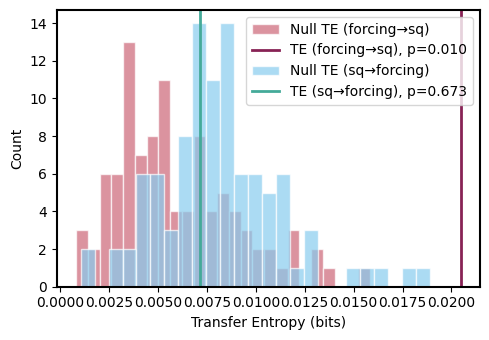

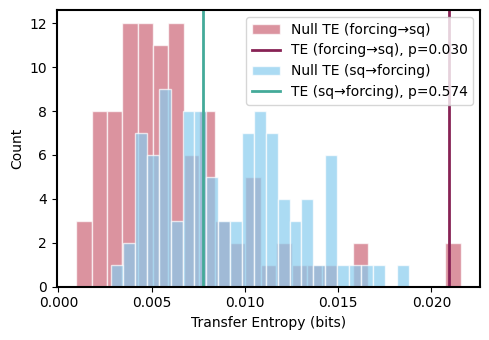

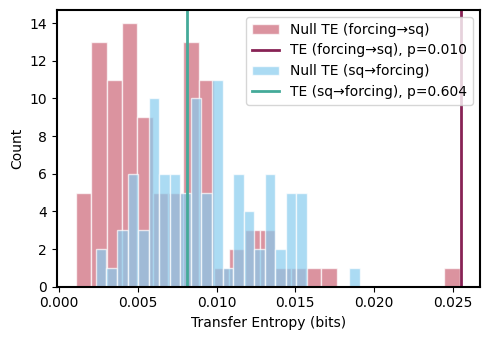

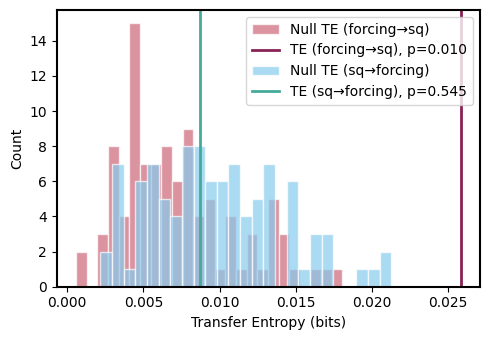

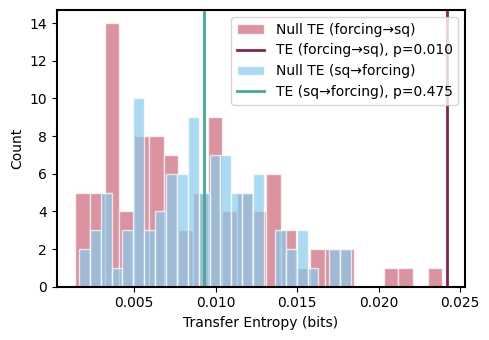

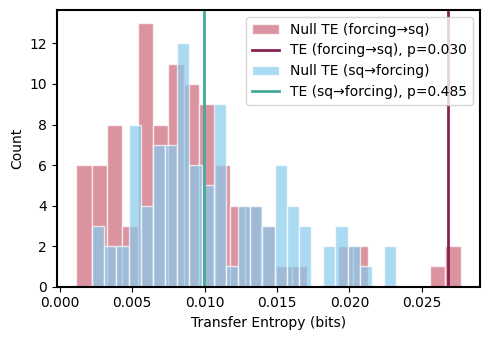

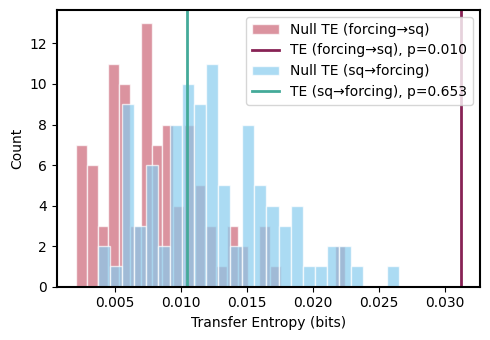

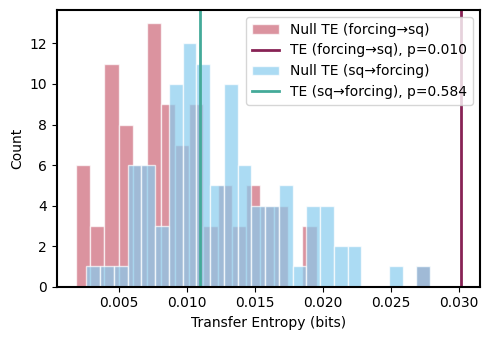

In [19]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

for interval in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]:
    df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=interval, if_plot=False)

    pre = df_pre_i['pre'].values      # source (precession)
    sq = df_sq_i['sq'].values    # target (residual)

    result,fig=sa.transfer_entropy_surrogate_test(pre,sq)
    result
    # fig.savefig(f'TE_NGRIP_{interval}.pdf',format='pdf',bbox_inches='tight')



In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=100, if_plot=False)

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, k=1, forcing_bins=4)
result

# Changes in lag and bin numbers

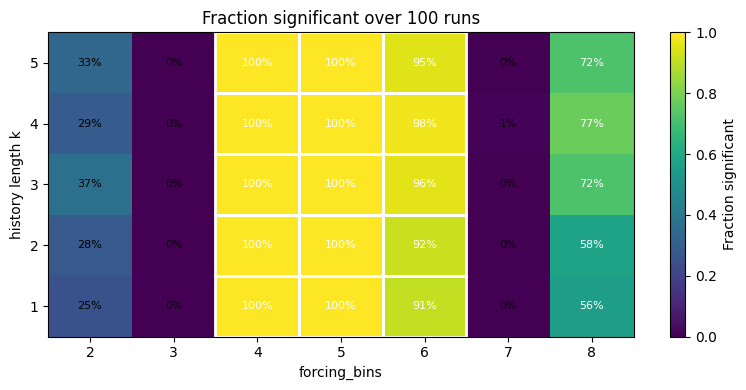

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa
import importlib

# reload in case you tweak the function
importlib.reload(sa)

# --- 0) settings ---
niter   = 100           # Monte Carlo repetitions
p_thresh = 0.9          # fraction threshold for boxing

# --- 1) prepare your fixed time series once ---
df_sq_i, df_pre_i, _ = sa.interpolate_data_forcing(
    df_sq.copy(),
    interval=10,
    if_plot=False
)
pre = df_pre_i['pre'].values
sq  = df_sq_i['sq'].values

# --- 2) define the parameter grid ---
ks     = [1, 2, 3, 4, 5]
gbins  = list(range(2, 9))   # 2 through 8 inclusive

# matrix to accumulate counts of "significant" outcomes
counts = np.zeros((len(ks), len(gbins)), dtype=int)

# --- 3) Monte Carlo loop ---
for it in range(niter):
    for i, k in enumerate(ks):
        for j, b in enumerate(gbins):
            sig, _ = sa.transfer_entropy_surrogate_test(
                pre, sq,
                k=k,
                forcing_bins=b,
                # leave sq_bins at its default of 2
                n_surr=100,
                p=0.05,
                if_plot=False
            )
            counts[i, j] += int(sig)

# compute the fraction of runs significant
fractions = counts / niter


# --- 4) plot the 2D heatmap of fractions ---
fig, ax = plt.subplots(figsize=(8, 4))

im = ax.imshow(
    fractions,
    origin='lower',        # so k=1 is bottom row
    aspect='auto',
    cmap='viridis',
    vmin=0, vmax=1
)

# ticks & labels
ax.set_xticks(np.arange(len(gbins)))
ax.set_xticklabels(gbins)
ax.set_xlabel('forcing_bins')

ax.set_yticks(np.arange(len(ks)))
ax.set_yticklabels(ks)
ax.set_ylabel('history length k')

ax.set_title(f'Fraction significant over {niter} runs')

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Fraction significant')

# --- outline cells where fraction > p_thresh with white box ---
for i, j in zip(*np.where(fractions > p_thresh)):
    rect = plt.Rectangle(
        (j-0.5, i-0.5),   # (x, y) corner
        width=1, height=1,
        fill=False,
        edgecolor='white',
        linewidth=2
    )
    ax.add_patch(rect)

# --- annotate every cell with percentage ---
for i in range(len(ks)):
    for j in range(len(gbins)):
        pct = fractions[i, j] * 100
        # choose text color for contrast
        txt_color = 'white' if fractions[i, j] > 0.5 else 'black'
        ax.text(
            j, i, f"{pct:.0f}%",
            ha='center', va='center',
            color=txt_color,
            fontsize=8
        )

plt.tight_layout()
plt.show()


# # --- 4) plot the 2D heatmap of fractions ---
# fig, ax = plt.subplots(figsize=(8, 4))

# im = ax.imshow(
#     fractions,
#     origin='lower',        # so k=1 is bottom row
#     aspect='auto',
#     cmap='viridis',
#     vmin=0, vmax=1
# )

# # ticks & labels
# ax.set_xticks(np.arange(len(gbins)))
# ax.set_xticklabels(gbins)
# ax.set_xlabel('forcing_bins')

# ax.set_yticks(np.arange(len(ks)))
# ax.set_yticklabels(ks)
# ax.set_ylabel('history length k')

# ax.set_title(f'Fraction significant over {niter} runs')

# # colorbar
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Fraction significant')

# # --- 5) outline cells where fraction > p_thresh ---
# for i, j in zip(*np.where(fractions > p_thresh)):
#     # rectangle centered on cell (j, i)
#     rect = plt.Rectangle(
#         (j-0.5, i-0.5),   # (x, y) corner
#         width=1, height=1,
#         fill=False,
#         edgecolor='black',
#         linewidth=2
#     )
#     ax.add_patch(rect)

# plt.tight_layout()
# plt.show()


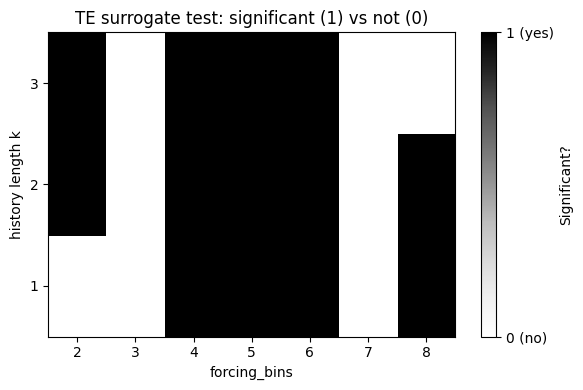

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa
import importlib

# reload in case you tweak the function
importlib.reload(sa)

# --- 1) prepare your fixed time series once ---
df_sq_i, df_pre_i, _ = sa.interpolate_data_forcing(
    df_sq.copy(), interval=10, if_plot=False
)
pre = df_pre_i['pre'].values
sq  = df_sq_i['sq'].values

# --- 2) define the parameter grid ---
ks     = [1, 2, 3]
gbins  = list(range(2, 9))   # 2 through 8 inclusive

# matrix to hold 0/1 results
results = np.zeros((len(ks), len(gbins)), dtype=int)

# --- 3) loop over all combos and run the test ---
for i, k in enumerate(ks):
    for j, b in enumerate(gbins):
        sig, _ = sa.transfer_entropy_surrogate_test(
            pre, sq,
            k=k,
            forcing_bins=b,
            # leave sq_bins at its default (2)
            n_surr=100,
            p=0.05,
            if_plot=False
        )
        results[i, j] = int(sig)   # 1 if significant, 0 otherwise

# --- 4) plot the 2D binary map ---
fig, ax = plt.subplots(figsize=(6, 4))

# use a grayscale colormap: 0→white, 1→black
im = ax.imshow(results, 
               origin='lower',    # so k=1 is on bottom row
               aspect='auto', 
               cmap='Greys',
               interpolation='nearest')

# tick labels
ax.set_xticks(np.arange(len(gbins)))
ax.set_xticklabels(gbins)
ax.set_xlabel('forcing_bins')

ax.set_yticks(np.arange(len(ks)))
ax.set_yticklabels(ks)
ax.set_ylabel('history length k')

ax.set_title('TE surrogate test: significant (1) vs not (0)')

# colorbar legend
cbar = fig.colorbar(im, ticks=[0,1], ax=ax)
cbar.ax.set_yticklabels(['0 (no)', '1 (yes)'])
cbar.set_label('Significant?')

plt.tight_layout()
plt.show()
